## Variational Autoencoder with MNIST Dataset

**Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

**Parameters**

In [2]:
BATCH_SIZE=128
LATENT_DIM=2

**Prepare the Dataset**

In [3]:
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  return image


def get_dataset(map_fn, is_validation=False):
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [4]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
for imagen in train_dataset.take(1):
  print(imagen.shape)

(128, 28, 28, 1)


**Build the Model**

The "Sampling" class will be created. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon $$

where $\mu$ = mean, $\sigma$ = standard deviation and $\epsilon$ = random sample

In [6]:
tf.keras.backend.random_normal(shape=(4,3))

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 1.1131126 , -0.24577841, -0.701933  ],
       [-0.6278802 ,  0.6763966 ,  1.459553  ],
       [ 0.10314874, -0.47937503,  0.2976374 ],
       [-0.02184051,  0.99192667,  1.195973  ]], dtype=float32)>

In [8]:
tf.random.normal(shape=(4,3))

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[-0.5516399 , -1.3831828 , -0.32543492],
       [ 2.2880423 ,  1.0770307 ,  1.1412002 ],
       [ 0.96755755, -0.52529395,  0.23981135],
       [-1.3280739 ,  0.4857137 ,  0.32806212]], dtype=float32)>

In [6]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):

    mu, sigma = inputs 

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    return mu + tf.exp(0.5 * sigma) * epsilon

**Encoder**

In [7]:
def encoder_layers(inputs, latent_dim):

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  batch_2 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [8]:
def encoder_model(latent_dim, input_shape):

  inputs = tf.keras.layers.Input(shape=input_shape)

  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  z = Sampling()((mu, sigma))

  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

**Decoder**

In [9]:
def decoder_layers(inputs, conv_shape):

  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)

  return x

In [10]:
def decoder_model(latent_dim, conv_shape):

  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  outputs = decoder_layers(inputs, conv_shape)

  model = tf.keras.Model(inputs, outputs)

  return model

**Kullback–Leibler Divergence**

In [11]:
def kl_reconstruction_loss(mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

**VAE Model**

In [12]:
def vae_model(encoder, decoder, input_shape):

  inputs = tf.keras.layers.Input(shape=input_shape)

  mu, sigma, z = encoder(inputs)

  reconstructed = decoder(z)

  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  loss = kl_reconstruction_loss(mu, sigma)
  model.add_loss(loss)

  return model

In [13]:
def get_models(input_shape, latent_dim):
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [14]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

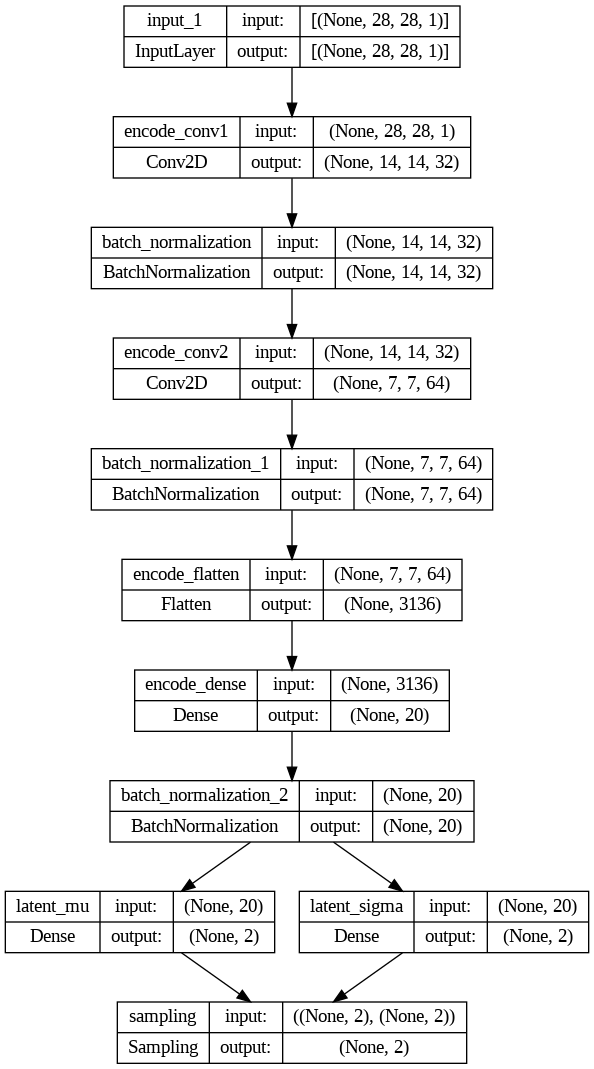

In [15]:
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

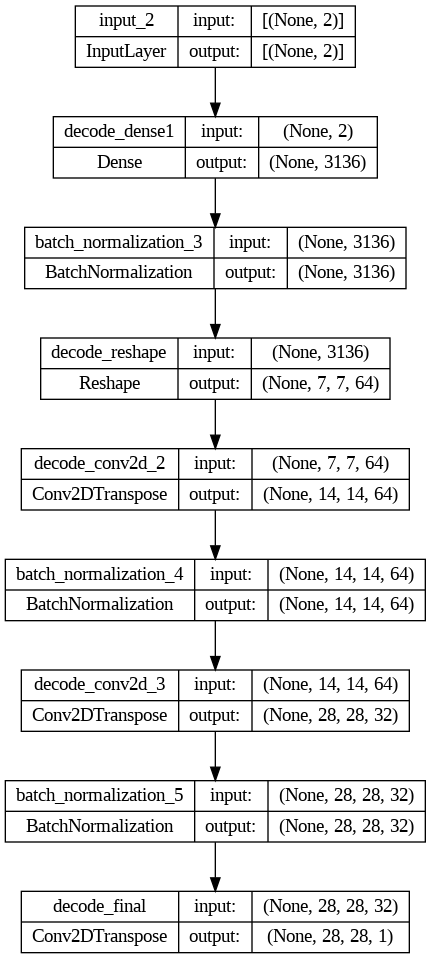

In [16]:
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_names=True)

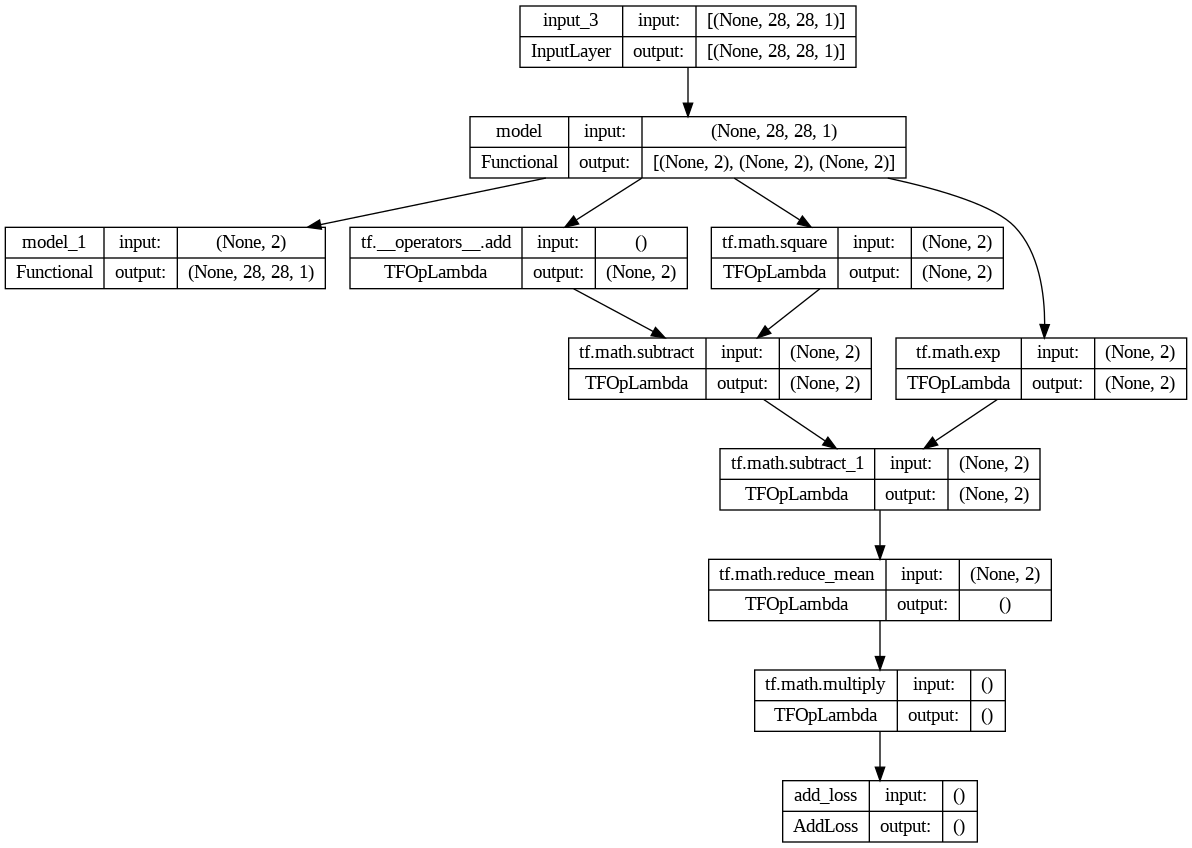

In [18]:
tf.keras.utils.plot_model(vae, show_shapes=True, show_layer_names=True)

**Train the Model**

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [20]:
def generate_and_save_images(model, epoch, step, test_input):

  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 [==============================] - 0s 18ms/step


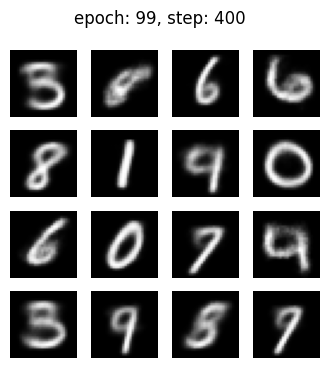

Epoch: 99 step: 400 mean loss = 144.21112


In [21]:
# Training loop.

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

epochs = 100

generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      reconstructed = vae(x_batch_train)

      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      loss += sum(vae.losses)

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))